# L4 – Word embedding

### Resources
1. Possible [truncated svd](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD) implementation of sklearn.
2. Tensorflow [tutorial](https://www.tensorflow.org/tutorials/word2vec) for word2vec and [implementation](https://github.com/tensorflow/models/tree/master/tutorials/embedding).
3. GloVe [site](https://nlp.stanford.edu/projects/glove/).
4. FastText [site](https://fasttext.cc).
5. [Gensim](https://radimrehurek.com/gensim/) library.

**Word embedding** – the collective name for a set of language modeling and feature learning techniques in natural language processing where words or phrases from the vocabulary are mapped to vectors of real numbers. Conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with much higher dimensionality. Word and phrase embeddings, when used as the underlying input representation, have been shown to boost the performance in NLP tasks such as syntactic parsing, sentiment analysis and translation. Usually, problem reduces to unsupervised learning on a large corpus of text. So, learning process is based on the idea that context of word closely associated with it. For example, the context can be a document in which the word is located or adjacent words.

### 1. Data

As text corpus you may use simple english [wikipedia](https://simple.wikipedia.org/wiki/Simple_English_Wikipedia).
1. 131K articles
2. 2K common English words.

Also you can use just english [wikipedia](https://en.wikipedia.org/wiki/Wikipedia):
1. Includes 5М+ articles
2. 2M+ different tokens

#### Exercises
1. Download all wikipedia articles.
2. Make all preprocessing work that you need (e.g. remove markup).

In [48]:
import numpy as np
import tf_glove
from gensim.corpora import WikiCorpus
from gensim.models import TfidfModel
from gensim.models import Word2Vec
from scipy.sparse import coo_matrix
import tensorflow as tf
from gensim.models import FastText
import re
import nltk
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def eucledian_dist(a, b):
    return (sum((a - b)**2))**0.5

def cosine_dist(a, b):
    return np.dot(a.T, b) / (sum(a**2)**0.5 * sum(b**2)**0.5)

def find_neigh(word, vectors, n_neigh, metric):
    distances = []
    word_id = word2id[word]
    for i in range(len(vectors)):
        distances.append([i, metric(vectors[word_id], vectors[i])])
    
    if metric == eucledian_dist:
        distances.sort(key = lambda x: x[1])
    if metric == cosine_dist:
        distances.sort(key = lambda x: -x[1])
    
    nearest_neighs = []
    for k in range(1, n_neigh + 1):   # Пропускаем word
        nearest_neighs.append(id2word[distances[k][0]])
    return nearest_neighs

def knn(target_word, model, n_neighs, metric):
    distances = []
    for word in word2id.keys():
        try: 
            distances.append([word, metric(model.wv[target_word], model.wv[word])])
        except:
            continue
    
    if metric == eucledian_dist:
        distances.sort(key = lambda x: x[1])
    if metric == cosine_dist:
        distances.sort(key = lambda x: -x[1])
    
    nearest_neighs = []
    for k in range(1, n_neighs + 1):   # Пропускаем target_word
        nearest_neighs.append(distances[k][0])
    return nearest_neighs

In [3]:
data = WikiCorpus(
    './simplewiki-20170820-pages-meta-current.xml.bz2', 
    processes=4,
    token_max_len=12,
    token_min_len=3
)

In [4]:
words_count = len(data.dictionary)
docs_count = len(data)
print(words_count, docs_count)

# Отфильтруем слова, встречающиеся слишком редко и слишком часто
data.dictionary.filter_extremes(no_below=10, no_above=0.15)
words_count = len(data.dictionary)
print(words_count)

word2id = dict()
for elem in data.dictionary:
    word2id.update({data.dictionary[elem]:elem})
    
id2word = dict()
for elem in data.dictionary:
    id2word.update({elem:data.dictionary[elem]})

440999 75245
49156


In [4]:
sentences = list(data.get_texts())

### 2. LSA (Latent semantic analysis)
This solution uses full document as a context of word. So, we have some vocabulary $W$ and a set of documents $D$. Matrix $X$ with shape $|W| \times |D|$ at position $w, d$ stores importance of word $w$ for document $d$. If word $w$ is not found in the document $d$ than at appropriate position $X$ has 0 (obviously, matrix is sparse).

For each matrix you can find [SVD decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition)
$$X = U \Sigma V^{T} \text{, где }$$
* $U$ – orthogonal matrix $|W| \times |W|$ of left singular vectors
* $\Sigma$ – diagonal matrix $|W| \times |D|$ of singular values
* $V$ – orthogonal matrix $|D| \times |D|$  of right singular vectors

Let's suppouse that row $w$ in matrix $U\Sigma$ is a vector that represents word $w$, and row $d$ of $V$ coresponds to document $d$. In some sense we already found the embeddings of words and documents at the same time. But size of vectors are determined by documents number $|D|$.

Nevertheless you can use truncated SVD instead
$$ X \approx X_k = U_k \Sigma_k V^{T}_k \text{, where }$$
* $U_k$ – $k$ left singular vectors
* $\Sigma_k$ – diagonal matrix $|k| \times |k|$ of largest singular values
* $V_k$ – $k$ right singular vectors

Also it known that $X_k$ is the best approximation of $X$ in the term of [Frobenius norm](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm) for all matrices of rank $k$.

So, it is possible to obtain a compressed words' representations of size $k \ll |W|$ as rows of matrix $U_k \Sigma_k $. It just remains to understand how to calculate the original values of the matrix $X$. There is a set of approaches, here are some of them
1. Binary flag that document contains the word.
2. The number occurrences of word in document.
3. Word frequency that is better known as $tf$ (it's possible also use $\ln(1 + tf)$).
4. [$tf \cdot idf$](https://ru.wikipedia.org/wiki/TF-IDF).

#### Further readning
1. You also can read this [aticle](https://en.wikipedia.org/wiki/Latent_semantic_analysis).
2. By the way, some [modification](http://www.netflixprize.com/assets/GrandPrize2009_BPC_BellKor.pdf) of SVD decompostion won at [Netflix prize](https://en.wikipedia.org/wiki/Netflix_Prize).
3. It is easy to see that the problem of SVD decomposition is reduced to finding eigenvectors of matrix $X \cdot X^T$.
4. You can find [here](https://arxiv.org/abs/0909.4061) probabilistic algorithms of matrix decomposition.

#### Exercises
1. Find matrix $X$, using you favourite approach (maybe you need the sparse matrix class of scipy library).
2. Find word embeddings of size $k = 128$.
3. Implement k-nearest neighbor search for Euclidean norm.
4. Find 10 nearest words for the set of words: 'cat', 'loves', 'clever' and 'mandarin'.
5. Repeat experiment for cosinus as metric. What are the results?

In [11]:
tfidf = TfidfModel(data, data.dictionary)

In [32]:
words_ids = []
docs_ids = []
values = []
for doc_id, content in enumerate(tfidf[data]):
    for word in content:
        words_ids.append(word[0])
        values.append(word[1])
        docs_ids.append(doc_id)
        
X = coo_matrix((values, (words_ids, docs_ids)), [words_count, docs_count])

In [36]:
svd = TruncatedSVD(n_components=128, n_iter=5, random_state=1)
X_k = svd.fit_transform(X)

In [78]:
print("Евклидова метрика:")
print("Ближайшие к слову cat:", find_neigh('cat', X_k, 10, eucledian_dist))
print("Ближайшие к слову loves:", find_neigh('loves', X_k, 10, eucledian_dist))
print("Ближайшие к слову clever:", find_neigh('clever', X_k, 10, eucledian_dist))
print("Ближайшие к слову mandarin:",find_neigh('mandarin', X_k, 10, eucledian_dist))

Евклидова метрика:
Ближайшие к слову cat: ['cats', 'breed', 'dogs', 'bear', 'fur', 'dog', 'eyes', 'grey', 'spider', 'snake']
Ближайшие к слову loves: ['likes', 'funny', 'mom', 'ugly', 'wonderful', 'magical', 'proud', 'aunt', 'sees', 'curse']
Ближайшие к слову clever: ['wakes', 'jealous', 'realize', 'frightened', 'honest', 'shocked', 'bored', 'cared', 'pleased', 'dostoevsky']
Ближайшие к слову mandarin: ['simplified', 'cantonese', 'taiwanese', 'macau', 'guangdong', 'manchu', 'chen', 'mongolian', 'guangzhou', 'zhang']


In [79]:
print("Косинусная метрика:")
print("Ближайшие к слову cat:", find_neigh('cat', X_k, 10, cosine_dist))
print("Ближайшие к слову loves:", find_neigh('loves', X_k, 10, cosine_dist))
print("Ближайшие к слову clever:", find_neigh('clever', X_k, 10, cosine_dist))
print("Ближайшие к слову mandarin:",find_neigh('mandarin', X_k, 10, cosine_dist))

Косинусная метрика:
Ближайшие к слову cat: ['cats', 'kittens', 'dog', 'tabby', 'siamese', 'pet', 'paws', 'haired', 'feline', 'breed']
Ближайшие к слову loves: ['friends', 'friend', 'happy', 'ugly', 'girl', 'likes', 'mom', 'witch', 'wakes', 'funny']
Ближайшие к слову clever: ['angry', 'really', 'telling', 'jealous', 'friend', 'knows', 'proud', 'friends', 'knew', 'thinks']
Ближайшие к слову mandarin: ['cantonese', 'simplified', 'hokkien', 'proficiency', 'rén', 'chinese', 'hakka', 'tungusic', 'pinyin', 'hanyu']


### 3. word2vec
Let's consider perhaps the most popular model of word embeddings. This is mainly due to the fact that the received vectors have interesting properties. In particular, semantically similar words have close vectors, moreover linear operation of subtraction has meaning in the resulting vector space! The context of word at this time is a window of size $2c+1$, where interested word is located in the middle.

#### Continuous bag-of-words
The core idea is very simple. There is some very long text
$$w_1, w_2, \dots, w_T.$$
Consider some word $w_t$ and its context in radius $c$, namely words
$$w_{t-c}, \dots, w_{t-1}, w_{t+1}, \dots w_{t+c}.$$
Intuition tells us that the context often really well defines the word in the middle. Then let our model restore the central word if its context is known
$$\mathcal{L} = - \frac{1}{T}\sum_{t} \log \mathbb{P}[w_t|w_{t-c}, \dots, w_{t-1}, w_{t+1}, \dots w_{t+c}].$$

For each word $w_t$ there is some vector $v_t$, but if word $w_{t+i}$ is some context than we use vector $v'_{t+i}$. In this case we can represent context of word as the following sum
$$s'_t = \sum_{c \leq i \leq c, i \neq 0} v'_{t+i}$$

And define probabilty with softmax
$$\mathbb{P}[w_t|w_{t-c}, \dots, w_{t-1}, w_{t-1}, \dots w_{t+c}] = \frac{ \exp {s'}_t^T \cdot v_t}{\sum_j \exp {s'}_t^T \cdot v_j}.$$

Note that this model is easy to present as 2-layer neural network:
* The input is a sparse vector of dimension $|W|$ which at position $w'$ has one if word $w'$ is in context.
* Further, we have matrix $V'$ of vectors $v'$.
* Further, without any non-linearity matrix $V$ of vector $v$.
* And then the softmax layer.

#### Skip-gram
Another model predicts context for some word. The design is approximately the same, we need to optimize
$$\mathcal{L} = -\frac{1}{T} \sum_t \sum_{-c \leq i \leq c, i \neq 0} \mathbb{P}[w_{t+i}|w_t].$$

The probability is approximated by the following model
$$\mathbb{P}[w_{t+i}|w_t] = \frac{ \exp {v'}_{t+i}^T \cdot v_t}{\sum_j \exp {v'}_{j}^T \cdot v_t}.$$


#### Hierarchical softmax
Creation of this mode was guided to reduce the complexity of learning. However, computing of sofmax's denominator is really expensive operation. Therefore, in practice, a few other models are used.

This method was viewed in the seminar. Detailed information can be found [here](http://www.iro.umontreal.ca/~lisa/pointeurs/hierarchical-nnlm-aistats05.pdf) and practical using [here](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).    Briefly recall, for each word from the dictionary we define [Huffman code](https://en.wikipedia.org/wiki/Huffman_coding). More frequency words have shorter code. Then we construct the Huffman tree. In accordance with its code words are stored in leaves. In the non-leaf vertices are stored special hidden representations $h'$. 

$$\mathbb{P}[w_{t+i}|w_t] = \prod_{{h'}_{t+i}, r} \sigma\Big( \mathcal{r} \cdot {h'}^T_{t+i} v_t \Big) \text{, where}$$
* ${h'}_{t+i}$ - hidden vector of word's path $w_{t+i}$
* $\mathcal{r}$ - equals $-1$, if we turn left and $+1$ in another case
* $\sigma$ - sigmoid function

Using hierarchical softmax as approximation of softmax allows us to significantly reduce complexity of model training. 

#### Exercise
1. How can you implement skip-gram model as neural network.
2. Estimate complexity of one iteration of training the skip-gram model
  * $T$ - text size
  * $W$ - vocabulary size
  * $c$ - context radius
  * $d$ - embedding size
3. Estimate complexity of using hierarchical softmax in the skip-gram model.

1. Вход сети: вектор размера (1, W), в котором стоит единичка на позиции, соотвтествующей слову, для которого мы хотим предсказать контекст. Первым слоем мы умножаем вектор на матрицу $V$, в которой хранятся представления слов из словаря(эта матрица размера (W, d)). На выходе получаем представление $v_i$ слова $w_i$. Далее мы умножаем на матрицу контекстов $V'$(её размер (d, W)). Выходом будет вектор размера (1, W). К нему и применяем софтмакс. Ошибку считаем как сумму выходов, соответствующих тем словам, которые находились в контексте слова $w_i$.
2. Сначала происходит умножение матриц размером (1, W) и (W, d) (сложность $O(Wd)$), далее умножение вектора (1, d) на матрицу размера (d, W) (сложность $O(Wd)$). Предподсчет знаменателя в софтмаксе за $O(W)$ далее за $O(1)$ считаем каждый выход(всего $W$ выходов). Далее нужно просуммировать $c$ выходов для вычисления ошибки. Обновляем веса матриц $V$ и $V'$ за $O(Wd)$. Такие действия на каждой итерации нужно проделать для всех $T$ слов из корпуса $2c-1$ раз. Итоговая сложность $O(WdTc)$

#### Why sampling?
Let see at softmax funciton
$$\mathbb{P}[x_i] = \frac{\exp f(x_i|\theta)}{\sum_j \exp f(x_j|\theta)}$$
Optimizing this function is equivalent to optimizing its logarithm
$$\log \frac{\exp f(x_i|\theta)}{\sum_j \exp f(x_j|\theta)} = f(x_i|\theta) - log \sum_j \exp f(x_j|\theta)$$
Than gradient $\triangledown_{\theta} \mathbb{P}[x_i]$ is equal to
$$\triangledown_{\theta} f(x_i|\theta) - \sum_k \frac{\exp f(x_k|\theta)}{\sum_j \exp f(w_j|\theta)} \triangledown_{\theta} f(x_k|\theta)$$
Inside the sum we can find $\mathbb{P}[x_k]$ again. So, the previous expression can be written as
$$
\triangledown_{\theta} f(x_i|\theta) - \sum_k \mathbb{P}[x_k] \cdot \triangledown_{\theta} f(x_k|\theta) = 
\triangledown_{\theta} f(x_i|\theta) - \mathbb{E}_{x \sim \mathbb{P}[x]} \triangledown_{\theta} f(x|\theta)
$$
If we can sample $x \sim \mathbb{P}[x]$, then we has no sense to calculate the softmax itself. We just can train model, computing only gradient. It is possible due to the fact that we do not need the probability itself, but want to find representation of words only.

#### Negative Sampling
As the result, in practice, softmax loss functions is approximated with negative sampling, which looks like a series of logistic regressions
$$\mathcal{L} = - \frac{1}{T}\sum_{w_t}
    \sum_{-c \leq i \leq c, i \neq 0} \Big(
        \mathbb{P}[y = 1 | w_{t+i}, w_t] -
        k \cdot \mathbb{E}_{\tilde{w}_{tj} \sim \mathbb{P}[w_j|w_t]} \mathbb{P}[y = 0 | \tilde{w}_{tj}, w_t]
    \Big)
$$
where $y=1$, if  word is a context of word and $y=0$ in another case. А $\tilde{w}_{tj}$ – sampling of words that don't belong to the context. Then main trick is how we will sample words $\mathbb{P}[y | w_{t+i}, w_t]$. In paper [noise contrastive estimation](https://www.cs.helsinki.fi/u/ahyvarin/papers/Gutmann10AISTATS.pdf) some interesting approaches is suggested. But we are going to use more simple variation
$$\mathcal{L} = - \frac{1}{T}\sum_{w_t} \Big(
    \sum_{-c \leq i \leq c, i \neq 0} \big(
        \sigma({v'}_{t+i}^T v_t) +
        k \cdot \mathbb{E}_{w_j \sim \mathbb{Q}(w_j)} \sigma (-{v'}_{j}^T v_t)
    \big)
\Big),
$$
to find  $\mathbb{E}_{\tilde{w}_{tj} \sim \mathbb{P}[w_j|w_t]}$ we simply sample words $k$ times from distribution $\mathbb{Q}$, $\mathbb{P}(w_j|w_t) = \mathbb{Q}(w_j)$.

#### Additional word2vec tricks
For the best quality at the moment of learning it is proposed to use variety of tricks:
1. How to choose $\mathbb{Q}$.
2. Sampling of frequent and rare words.
3. The sampling of window size.
You are welcome to read about this in original papers.

#### Further reading
1. Briefly about both models [here](https://arxiv.org/pdf/1301.3781.pdf).
2. Hierarchical softmax and negative sampling [here](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

#### Exercises
1. Train skip-gram model, using negative sampling and embedding size $d$ = 256. You are free to choose size of window and number of epochs.
2. Find top-10 nearest words again. Compare Euclidean and cosinus metric. Which is better? 
3. Find 10 nearest vector for expression v(king) - v(man) + v(women). If your model is tuned well, you find representation of word queen. 
4. How could you solve the following problems?
  * Find for country its capital
  * For a word find its plural form
  * For word define antonyms

In [119]:
w2v_model = Word2Vec(sentences, sg=1, size=256, window=5, min_count=0, workers=4, negative=20)
w2v_model.save('w2v_model')

In [59]:
print("Евклидова метрика:")
print("Ближайшие к слову cat:", knn('cat', w2v_model, 10, eucledian_dist))
print("Ближайшие к слову loves:", knn('loves', w2v_model, 10, eucledian_dist))
print("Ближайшие к слову clever:", knn('clever', w2v_model, 10, eucledian_dist))
print("Ближайшие к слову mandarin:", knn('mandarin', w2v_model, 10, eucledian_dist))

Евклидова метрика:
Ближайшие к слову cat: ['silvestris', 'ferret', 'cats', 'catus', 'ocelot', 'bobcat', 'kitten', 'ballou', 'scat', 'poodle']
Ближайшие к слову loves: ['dismay', 'annoy', 'annoys', 'motherly', 'comforts', 'imagines', 'admiring', 'hurries', 'realises', 'passionately']
Ближайшие к слову clever: ['likeable', 'talkative', 'unkind', 'thoughtful', 'obedient', 'adventurous', 'imaginative', 'sociable', 'joking', 'affectionate']
Ближайшие к слову mandarin: ['cantonese', 'hokkien', 'teh', 'chinese', 'xing', 'hanzi', 'hakka', 'balinese', 'proficiency', 'singaporeans']


In [60]:
print("Косинусная мера:")
print("Ближайшие к слову cat:", knn('cat', w2v_model, 10, cosine_dist))
print("Ближайшие к слову loves:", knn('loves', w2v_model, 10, cosine_dist))
print("Ближайшие к слову clever:", knn('clever', w2v_model, 10, cosine_dist))
print("Ближайшие к слову mandarin:", knn('mandarin', w2v_model, 10, cosine_dist))

Косинусная мера:
Ближайшие к слову cat: ['cats', 'felis', 'silvestris', 'ferret', 'dog', 'kitten', 'catus', 'poodle', 'leopardus', 'serval']
Ближайшие к слову loves: ['dismay', 'loved', 'likes', 'hates', 'annoy', 'annoys', 'motherly', 'imagines', 'comforts', 'love']
Ближайшие к слову clever: ['likeable', 'thoughtful', 'unkind', 'polite', 'talkative', 'stubborn', 'adventurous', 'playful', 'imaginative', 'obedient']
Ближайшие к слову mandarin: ['cantonese', 'hokkien', 'pinyin', 'chinese', 'bahasa', 'hakka', 'yue', 'hanyu', 'teh', 'xing']


In [70]:
print('"king"-"man"+"woman"=')
print(w2v_model.wv.most_similar(positive=['woman', 'king'], negative=['man']))

"king"-"man"+"woman"=
[('queen', 0.47827601432800293), ('regnant', 0.4768391251564026), ('melisende', 0.4623945653438568), ('catharina', 0.4580356776714325), ('æthelwulf', 0.45657381415367126), ('ethelred', 0.4543089270591736), ('ethelflaeda', 0.4540845453739166), ('unready', 0.45087820291519165), ('margrethe', 0.4489472806453705), ('leszczyńska', 0.4475284218788147)]


Можно попробовать найти столицу по названию страны следующим образом:
"berlin" - "german" + *country_name*

Примеры:

In [77]:
print('England:', w2v_model.wv.most_similar(positive=['berlin', 'england'], negative=['german'])[0])
print('Finland:', w2v_model.wv.most_similar(positive=['berlin', 'finland'], negative=['german'])[0])
print('Russia:', w2v_model.wv.most_similar(positive=['berlin', 'russia'], negative=['german'])[0])
print('Urkaine:', w2v_model.wv.most_similar(positive=['berlin', 'ukraine'], negative=['german'])[0])
print('Japan:', w2v_model.wv.most_similar(positive=['berlin', 'japan'], negative=['german'])[0])

England: ('london', 0.5198614597320557)
Finland: ('helsinki', 0.5757855176925659)
Russia: ('moscow', 0.5818648934364319)
Urkaine: ('lviv', 0.5231975317001343)
Japan: ('tokyo', 0.5488743185997009)


Множественную форму можно получить, например, прибавив ("chairs" - "chair")

Примеры:

In [84]:
print('Door:', w2v_model.wv.most_similar(positive=['chairs', 'door'], negative=['chair'])[0])
print('Tree:', w2v_model.wv.most_similar(positive=['chairs', 'tree'], negative=['chair'])[0])
print('Book:', w2v_model.wv.most_similar(positive=['chairs', 'book'], negative=['chair'])[0])
print('Trains:', w2v_model.wv.most_similar(positive=['chairs', 'train'], negative=['chair'])[0])
print('Window:', w2v_model.wv.most_similar(positive=['chairs', 'window'], negative=['chair'])[0])

Door: ('doors', 0.5131139159202576)
Tree: ('trees', 0.5580471754074097)
Book: ('books', 0.6026756763458252)
Trains: ('trains', 0.5420023798942566)
Window: ('hallways', 0.5364242792129517)


Антонимы можем попробовать получить, прибавив ("good"-"bad"). Однако зачастую слово и его антоним идут в одном контексте и поэтому сложно получить по слову антоним.

Примеры:

In [134]:
print('Sun:', w2v_model.wv.most_similar_cosmul(positive=['good', 'sun'], negative=['bad']))
print('Day:', w2v_model.wv.most_similar(positive=['good', 'day'], negative=['bad']))
print('Hot:', w2v_model.wv.most_similar(positive=['good', 'hot'], negative=['bad']))

Sun: [('phaethon', 0.9101213812828064), ('proxima', 0.9072478413581848), ('barycenter', 0.905835747718811), ('dimmer', 0.9020644426345825), ('sundials', 0.9019885659217834), ('cepheid', 0.9012718796730042), ('uranian', 0.9000887870788574), ('ganymede', 0.8998751044273376), ('zodiacal', 0.8971606492996216), ('tilts', 0.8968896865844727)]
Day: [('divali', 0.6168734431266785), ('naadam', 0.6103267669677734), ('norouz', 0.6065247654914856), ('postponing', 0.6048611402511597), ('libations', 0.6006574034690857), ('commemorated', 0.6004396677017212), ('fiftieth', 0.5981945991516113), ('hodesh', 0.5924360156059265), ('birthdays', 0.5911232829093933), ('monthlong', 0.586001455783844)]
Hot: [('bubbling', 0.5998260974884033), ('recurrents', 0.5940163135528564), ('billboard', 0.5798785090446472), ('ringtones', 0.5746988654136658), ('steamy', 0.5663763880729675), ('ofpositions', 0.5610558390617371), ('cool', 0.5607720017433167), ('grilling', 0.5567920804023743), ('buffets', 0.5565358996391296), ('f

### 4. GloVe
This model combines two ideas:
1. Factorization of the matrix, as in LSA
2. Context of word is adjacent words in the corpus, just in word2vec.

Let matrix $X$ at position $i,j$ stores how many times the word $j$ was found in the context of word $i$. This matrix is filled with our corpus of text. Then the probability that the word $j$ appears in the context of word $i$ is equal to
$$P_{ij} = \frac{X_{ij}}{\sum_k X_{ik}}$$

At the same time we want to find some function $F$ and word embeddings that 
$$F((w_i - w_j)^T w_k) = \frac{F(w_i^T w_k)}{F(w_j^T w_k)} = \frac{P_{ik}}{P_{jk}}.$$
About motivation it's better to read in the original [paper](http://nlp.stanford.edu/pubs/glove.pdf).
Possible solution may be following
$$\exp(w_i^T w_j) = P_{ij}.$$

After a series of transformations you can receive that
$$w_i^T w_j = \log X_{ij} - \log\big(\sum_k X_{ik}\big)$$

Obviously, right part doesn't depend on $j$, but the resulting model is offered to be written symmetry as
$$w_i^T w_j + b_i + b_j = \log X_{ij}$$

As loss function authors suggest to use weighted MSE
$$\mathcal{L} = \sum_{i,j = 1}^{|W|} f(X_{ij}) \Big(w_i^T w_j + b_i + b_j - \log(X_{ij}) \Big)^2,$$
where $f$ is some weight function, defined for each pair of words. It is reasonable to store $X$ as sparse matrix. It is also noteworthy that during training only **not null** values of $X$ used. Model is trained with stochastic gradient descent. As some way of regularization the authors suggest to use two different matrices $W$ и $W'$ for word and context, so model can be rewritten as
$$w_i^T {w'}_j + b_i + b_j = \log X_{ij}$$
The resulted embedding of a word is the sum of two trained views $w + w'$.

#### Some additional GloVe tricks
1. In order to understand how you can choose $f$, please, read the original paper.
2. Also you are welcome to see, how $X$ is formed in the original article.

#### Further reading
1. GloVe [site](http://nlp.stanford.edu/projects/glove/).
2. Some words about [t-SNE](http://lvdmaaten.github.io/tsne/).

#### Exercises
1. Estimate complexity of model for one iteration. Choose appropriate $c$ for you.
2. Train GloVe word embeddings ($d$=256).
3. Check that v(king) - v(man) + v(women) is approximately equal v(queen).
4. Read about [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).
5. Use t-SNE to reduce the size of embeddings to 3. Make sure that the following groups of vectors are collinear (use visualization)
  * [man, woman], [Mr., Ms], [king, queen], etc
  * [CEO, company]
  * [adjective, its comparative form]

Для каждой пары слов из словаря считается ошибка(перемножение и сложение векторов длины d). Поэтому в худшем случае на один проход потребуется $O(W^2d)$ времени. Однако стоит учесть, что предлагаемая в статье функция $f$ на нулевых элементах $X_{ij}$ равна нулю и поэтому для большинства пар слов $(i, j)$ их вклад в общую функцию потерь будет нулевой. Поэтому реальные временные затраты сильно зависят от того, какой корпус подается на вход и от того, сколько слов в словаре.  

In [5]:
glove_model = tf_glove.GloVeModel(embedding_size=256, context_size=10, min_occurrences=12, max_vocab_size=10000,
                                  learning_rate=0.05, batch_size=512)

In [6]:
glove_model.fit_to_corpus(sentences)

In [8]:
glove_model.train(num_epochs=25, summary_batch_interval=1000)

In [56]:
target = glove_model.embedding_for("king") - glove_model.embedding_for("man") + glove_model.embedding_for("woman")
distances_eucledian = []
distances_cosine = []

for word in glove_model.words:
    distances_eucledian.append([word, eucledian_dist(target, glove_model.embedding_for(word))])
    distances_cosine.append([word, cosine_dist(target, glove_model.embedding_for(word))])

distances_eucledian.sort(key=lambda x: x[1])
distances_cosine.sort(key=lambda x: -x[1])
print(distances_cosine[:10])
print(distances_eucledian[:10])

[['king', 0.7264764152860983], ['woman', 0.65546481045402716], ['france', 0.35667439290866987], ['becomes', 0.35065259307957064], ['scotland', 0.29786239055443792], ['december', 0.29705756394955823], ['sweden', 0.29617064907932966], ['kingdom', 0.28841316540990719], ['england', 0.28764543128340381], ['charles', 0.27767897190169433]]
[['king', 7.400627466839536], ['king', 7.400627466839536], ['woman', 8.07894602330094], ['woman', 8.07894602330094], ['becomes', 10.12807623710699], ['becomes', 10.12807623710699], ['france', 10.322684684244155], ['france', 10.322684684244155], ['death', 10.468374344803332], ['death', 10.468374344803332]]


In [41]:
tsne_transformed = TSNE(n_components=3).fit_transform(glove_model.embeddings)

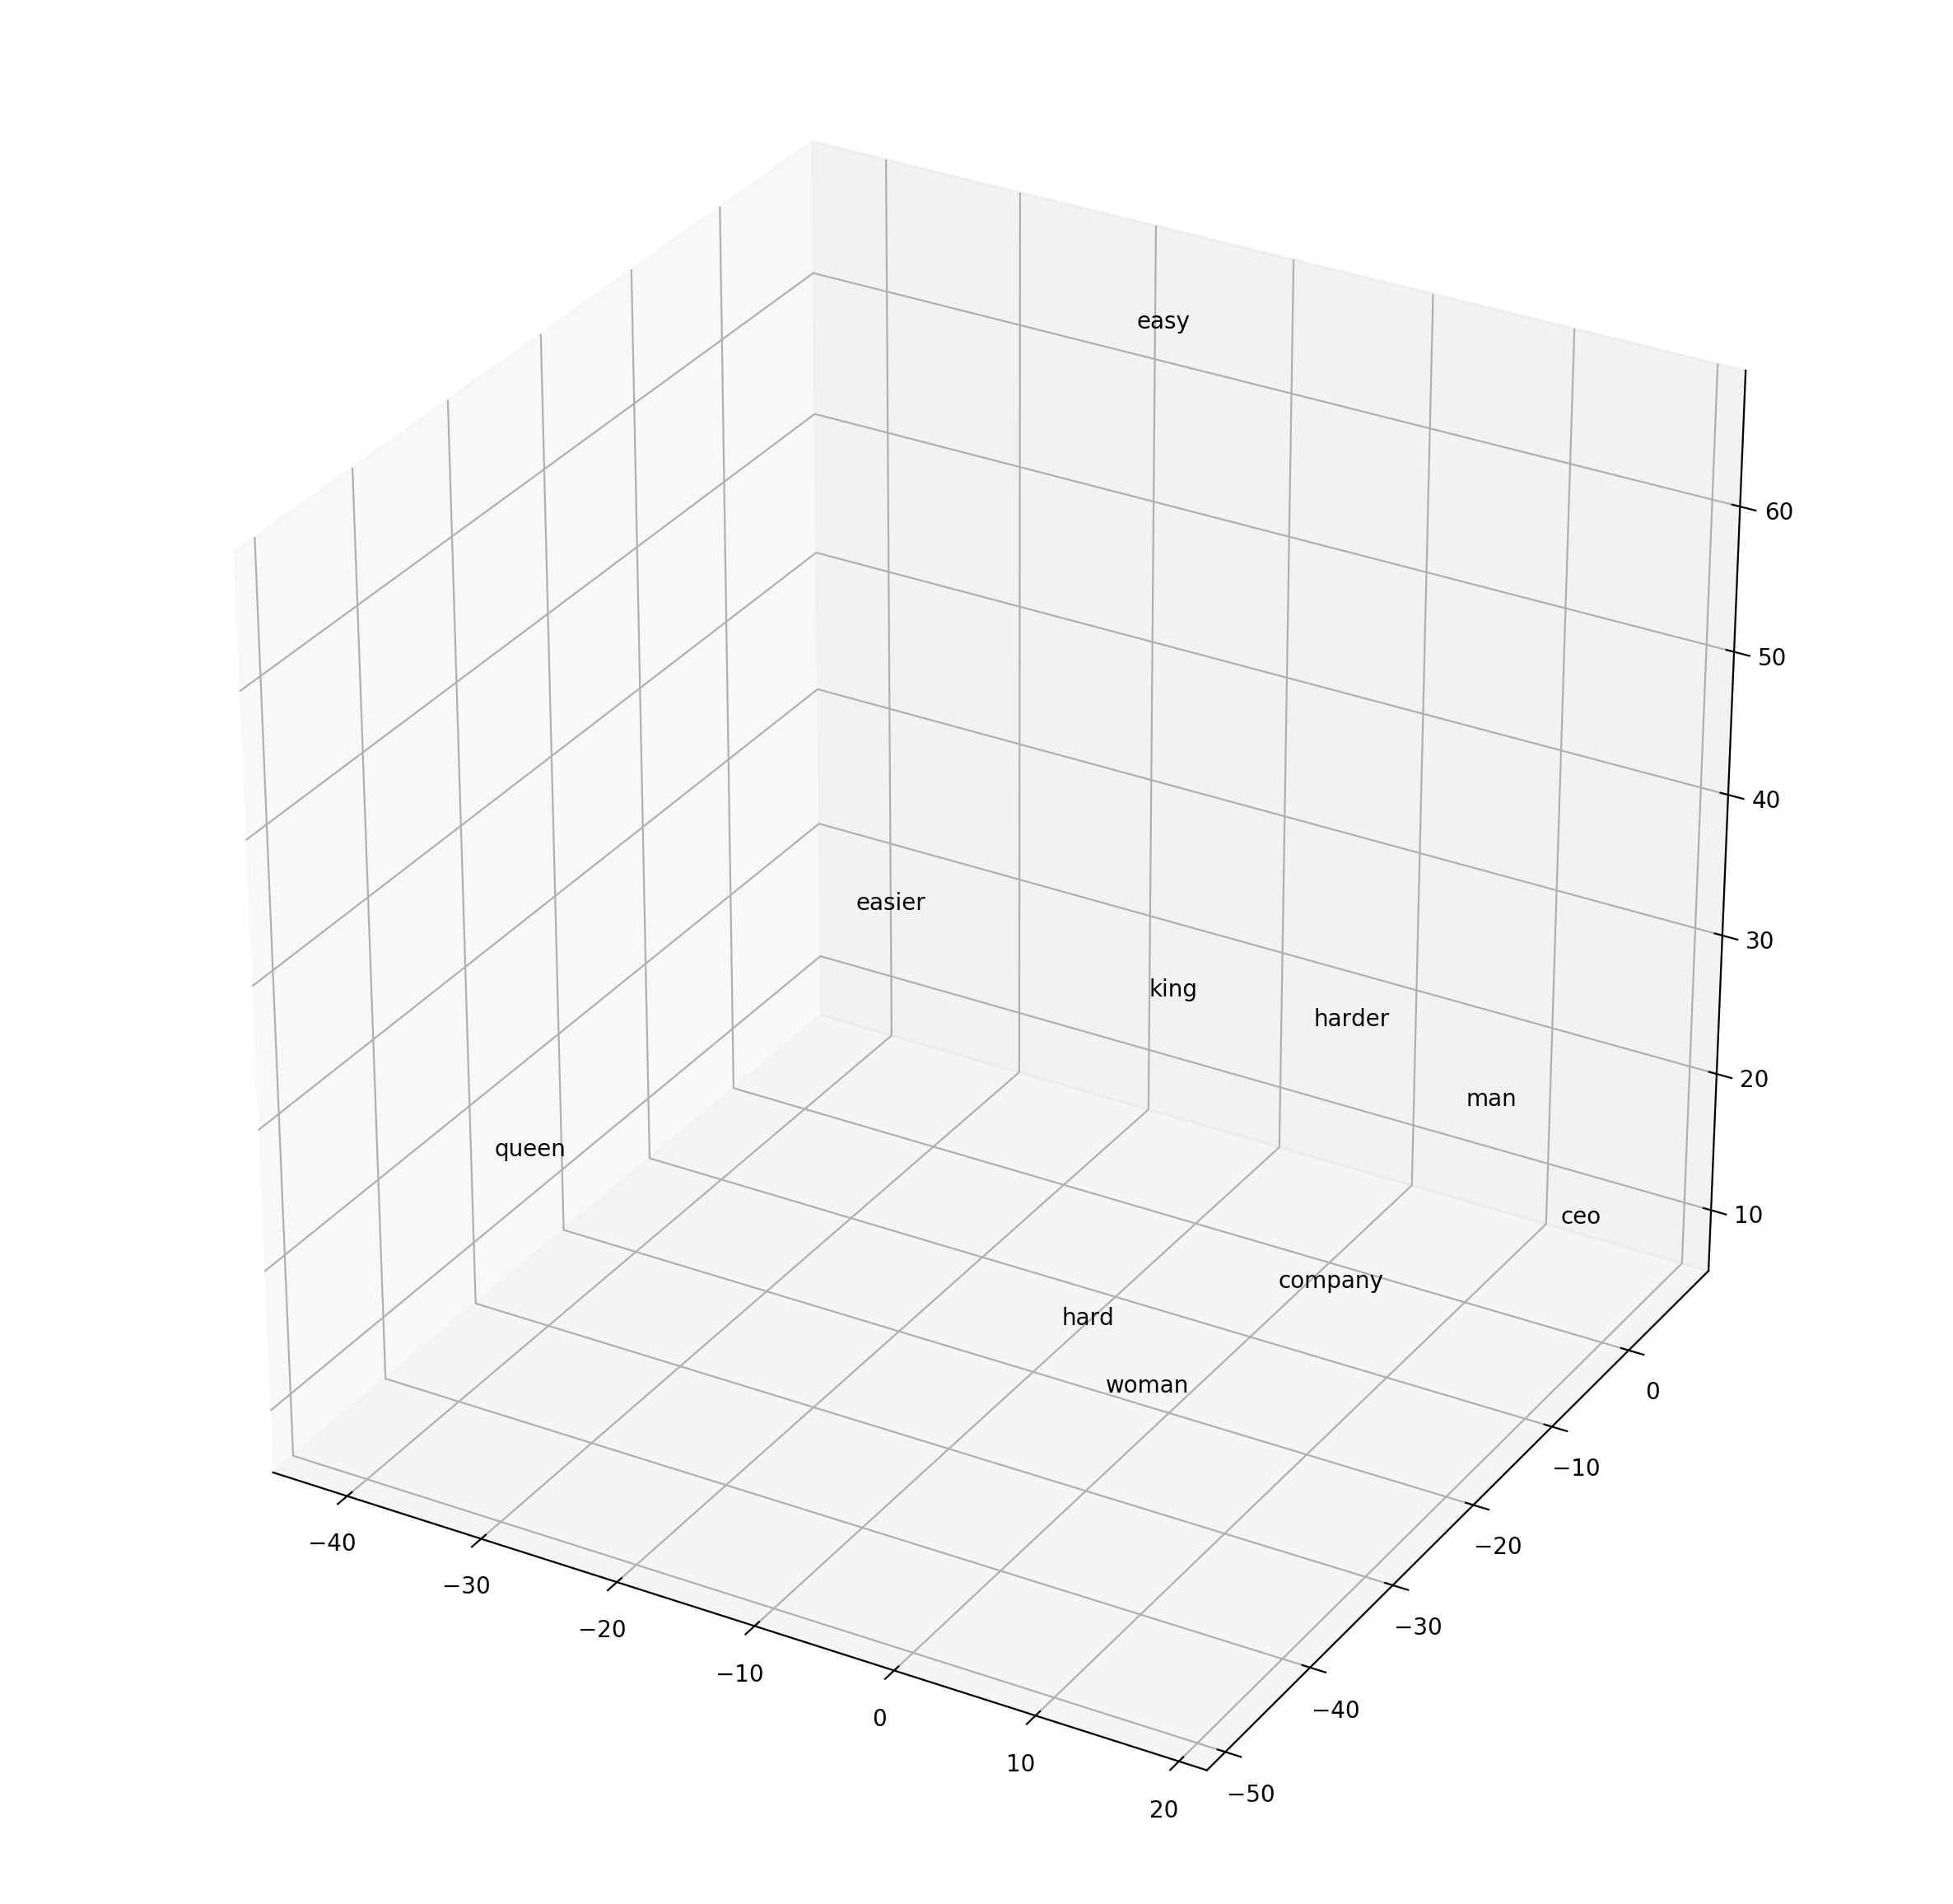

In [49]:
fig = plt.figure(figsize=(15,15),dpi=200) 
ax = fig.add_subplot(111, projection='3d')
for label in ['man', 'woman', 'king', 'queen', 'ceo', 'company', 'hard', 'harder', 'easy', 'easier']:
    x, y,z = tsne_transformed[glove_model.id_for_word(label)]
    ax.scatter(x,y,z, alpha=0)
    ax.text(x,y,z,label, ha='center',va='center')

### 5. FastText
[FastText](https://arxiv.org/pdf/1607.04606.pdf) is a logical development of skip-gram model. The core feature is to present the word as the sum of its n-grams embeddings and its own embedding vector. For example, if we want to use only 3-grams, than word **fast** be reprented as n-grams **-fa**, **fas**, **ast**, **st-** and word **-fast-**. The context is encoeded in usual way, as a result similarity of word and context word is the following sum
$$s(w, c) = \sum_{n \in N_w} z^{T}_n v'_{c},$$
where $N_w$ is the set of all n-grams of word $w$ combined with word itself. The authors argue that the use of combination of 3-,4- and 5-grams helps to get better embeddings for rare and even unknown words (emdedding of word itself is null vector). For model training is proposed to use negative sampling.

You can find more information on [site](https://fasttext.cc) of FastText.

#### Exercises
1. Train FastText word embeddings ($d$=256).
2. Find some rare words in your corpus and find top-5 nearest words for them, using cosinus as metric.
3. Compare results with classic word2vec.
4. Invent some funny new word and found its top-5 nearest words again.
5. How could you compare all models. Suggest your metric (see papers for inspiration).

In [95]:
fast_text_model = FastText(senteces, sg=0, size=256, window=3, min_count=15, sample=1e-3, workers=4, negative=20)
fast_text_model.save('fast_text_model')

In [108]:
freq_map = {}
for elem in word2id.keys():
    freq_map.update({elem:0})

for text in senteces:
    for word in text:
        if word in freq_map:
            freq_map[word] += 1
min_freq = 9999
for word in freq_map:
    if freq_map[word] < min_freq:
        min_freq = freq_map[word]
        
for word in freq_map:
    if freq_map[word] == min_freq:
        print(word)

In [125]:
print('Safeguarding:')
print('Fast-text:', knn('safeguarding', fast_text_model, 5, cosine_dist))
print('Word2Vec:', knn('safeguarding', w2v_model, 5, cosine_dist))
print('-----')
print('Unethical:')
print('Fast-text:', knn('unethical', fast_text_model, 5, cosine_dist))
print('Word2Vec:', knn('unethical', w2v_model, 5, cosine_dist))
print('-----')
print('Demoralized:')
print('Fast-text:', knn('demoralized', fast_text_model, 5, cosine_dist))
print('Word2Vec:', knn('demoralized', w2v_model, 5, cosine_dist))
print('-----')
print('Standardize:')
print('Fast-text:', knn('standardize', fast_text_model, 5, cosine_dist))
print('Word2Vec:', knn('standardize', w2v_model, 5, cosine_dist))

Safeguarding:
Fast-text: ['guarding', 'rewarding', 'safeguard', 'regarding', 'herding']
Word2Vec: ['stewardship', 'ordinate', 'standardize', 'modernising', 'suitability']
-----
Unethical:
Fast-text: ['ethical', 'ideological', 'cynical', 'umbilical', 'logical']
Word2Vec: ['experimenter', 'deprive', 'prevails', 'indifferent', 'hurtful']
-----
Demoralized:
Fast-text: ['legalized', 'demoted', 'hypnotized', 'delocalized', 'idealized']
Word2Vec: ['hastily', 'raged', 'thereon', 'disbanding', 'iraqis']
-----
Standardize:
Fast-text: ['standard', 'standardized', 'standards', 'standardised', 'substandard']
Word2Vec: ['safeguarding', 'bureaucratic', 'modernising', 'ordinate', 'auditing']


Видно, что word2vec на редких словах выдает совсем не похожие по смыслу слова. FastText в свою очередь очень хорошо себя показывает как на редких, так и на популярных словах

In [130]:
print('Shrimphead:', knn('shrimphead', fast_text_model, 5, cosine_dist))
print('Micerhino:', knn('micerhino', fast_text_model, 5, cosine_dist))
print('Sweatermoon:', knn('sweatermoon', fast_text_model, 5, cosine_dist))

Shrimphead: ['shrimps', 'loggerhead', 'moorhead', 'shrill', 'motörhead']
Micerhino: ['hino', 'rhino', 'gioacchino', 'gioachino', 'mino']
Sweatermoon: ['watermelon', 'heaters', 'moon', 'sweetwater', 'heater']


В теории GloVe является самым продвинутым методом, так как он учитывает общую статистику по всему корпусу и строит векторные представления, отражающие логическую связь между словами. В свою очередь LSA не способно строить такие векторные представления, то есть по сути алгоритм не учитывает "смысл" слов. Skip-gram модели не видят картину по всему тексту(что представляет собой довольно ценную информацию). 

Однако на практике GloVe оказался далеко не самым лучшим методом из представленных выше. Квадратичная зависимость от размера словаря не позволяет обучить векторные представления за время, которое требуется w2v или fast-text'y. 

w2v достаточно хорошо справился со своей задачей, при этом затратив не очень много времени. При том, что модель не учитывала общую статистику по всему корпусу, ей удалось построить достаточно качетсвенные векторные представления, отражающие смысл слов. Единственным минусом оказалось то, что на редко встречающихся словах были плохие результаты. Fast-text вобрал в себя все плюсы w2v, имея возможность улавливать смысл редко встречающихся слов(но синтаксически схожих со словами из корпуса)